In [27]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor


In [28]:
#Load Dataset
# Try UTF-8 first, fall back to latin1 if there is a UnicodeDecodeError
csv_path = 'Environment_Temperature_change_E_All_Data_NOFLAG.csv'
try:
	df = pd.read_csv(csv_path, encoding='utf-8')
except UnicodeDecodeError:
	df = pd.read_csv(csv_path, encoding='latin1')
	print(f"Read '{csv_path}' with latin1 encoding due to UnicodeDecodeError.")
	
# 3. Rename columns to consistent Python-friendly names (optional but recommended)
rename_map = {
    "Area Code": "Area_Code",
    "Area": "Area",
    "Months Code": "Month_Code",
    "Months": "Month",
    "Element Code": "Element_Code",
    "Element": "Element",
    "Unit": "Unit"
}
df = df.rename(columns=rename_map)

#show basic info
print(df.info())
print(df.head())


Read 'Environment_Temperature_change_E_All_Data_NOFLAG.csv' with latin1 encoding due to UnicodeDecodeError.
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9656 entries, 0 to 9655
Data columns (total 66 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Area_Code     9656 non-null   int64  
 1   Area          9656 non-null   object 
 2   Month_Code    9656 non-null   int64  
 3   Month         9656 non-null   object 
 4   Element_Code  9656 non-null   int64  
 5   Element       9656 non-null   object 
 6   Unit          9656 non-null   object 
 7   Y1961         8287 non-null   float64
 8   Y1962         8322 non-null   float64
 9   Y1963         8294 non-null   float64
 10  Y1964         8252 non-null   float64
 11  Y1965         8281 non-null   float64
 12  Y1966         8364 non-null   float64
 13  Y1967         8347 non-null   float64
 14  Y1968         8345 non-null   float64
 15  Y1969         8326 non-null   float64
 16  Y1970 

In [29]:
# 5. Reshape from wide (Y1961..Y2019) to long format
year_cols = [c for c in df.columns if c.startswith("Y")]

id_cols = ["Area_Code", "Area", "Month_Code", "Month", "Element_Code", "Element", "Unit"]

df_long = df.melt(
    id_vars=id_cols,
    value_vars=year_cols,
    var_name="Year",
    value_name="Value"
)

In [30]:
# 6. Convert Year to integer and Value to numeric
df_long["Year"] = df_long["Year"].str[1:].astype(int)   # "Y1961" -> 1961
df_long["Value"] = pd.to_numeric(df_long["Value"], errors="coerce")

print(df_long.info())
print(df_long.head())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569704 entries, 0 to 569703
Data columns (total 9 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   Area_Code     569704 non-null  int64  
 1   Area          569704 non-null  object 
 2   Month_Code    569704 non-null  int64  
 3   Month         569704 non-null  object 
 4   Element_Code  569704 non-null  int64  
 5   Element       569704 non-null  object 
 6   Unit          569704 non-null  object 
 7   Year          569704 non-null  int64  
 8   Value         491601 non-null  float64
dtypes: float64(1), int64(4), object(4)
memory usage: 39.1+ MB
None
   Area_Code         Area  Month_Code     Month  Element_Code  \
0          2  Afghanistan        7001   January          7271   
1          2  Afghanistan        7001   January          6078   
2          2  Afghanistan        7002  February          7271   
3          2  Afghanistan        7002  February          6078   
4          2 

In [31]:

# 7. Basic cleaning: drop rows with missing Value
df_long = df_long.dropna(subset=["Value"])

# Optional: reset index
df_long = df_long.reset_index(drop=True)

print(df_long.info())
print(df_long.head())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 491601 entries, 0 to 491600
Data columns (total 9 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   Area_Code     491601 non-null  int64  
 1   Area          491601 non-null  object 
 2   Month_Code    491601 non-null  int64  
 3   Month         491601 non-null  object 
 4   Element_Code  491601 non-null  int64  
 5   Element       491601 non-null  object 
 6   Unit          491601 non-null  object 
 7   Year          491601 non-null  int64  
 8   Value         491601 non-null  float64
dtypes: float64(1), int64(4), object(4)
memory usage: 33.8+ MB
None
   Area_Code         Area  Month_Code     Month  Element_Code  \
0          2  Afghanistan        7001   January          7271   
1          2  Afghanistan        7001   January          6078   
2          2  Afghanistan        7002  February          7271   
3          2  Afghanistan        7002  February          6078   
4          2 

C:\Users\HP\AppData\Local\Temp\ipykernel_13032\3933935855.py:10: UserWarning: Glyph 150 (\x96) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\HP\AppData\Roaming\Python\Python313\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 150 (\x96) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


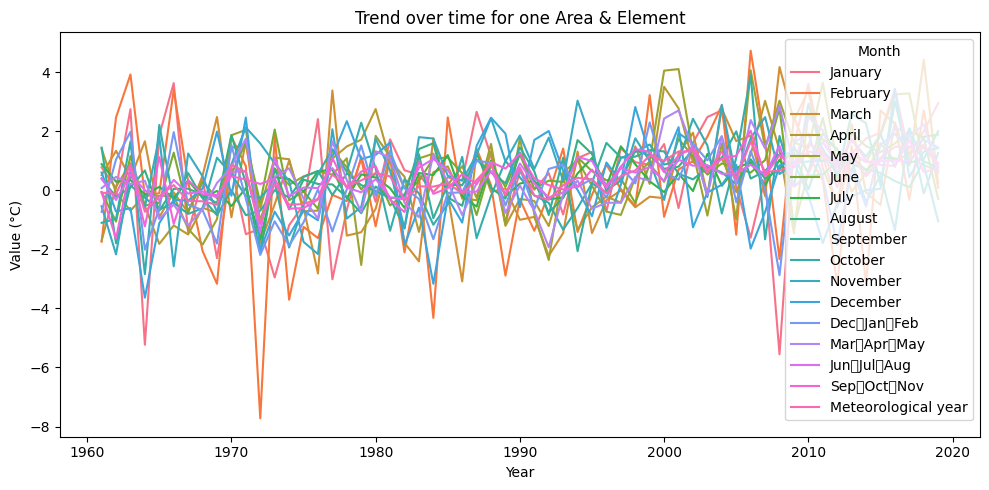

In [32]:
#Visualization
# a) Trend over time for one Area and Element
plt.figure(figsize=(10, 5))
subset = df_long[(df_long["Area"] == df_long["Area"].iloc[0]) &
                 (df_long["Element"] == df_long["Element"].iloc[0])]
sns.lineplot(data=subset, x="Year", y="Value", hue="Month")
plt.xlabel("Year")
plt.ylabel(f"Value ({subset['Unit'].iloc[0]})")
plt.title("Trend over time for one Area & Element")
plt.tight_layout()
plt.show()

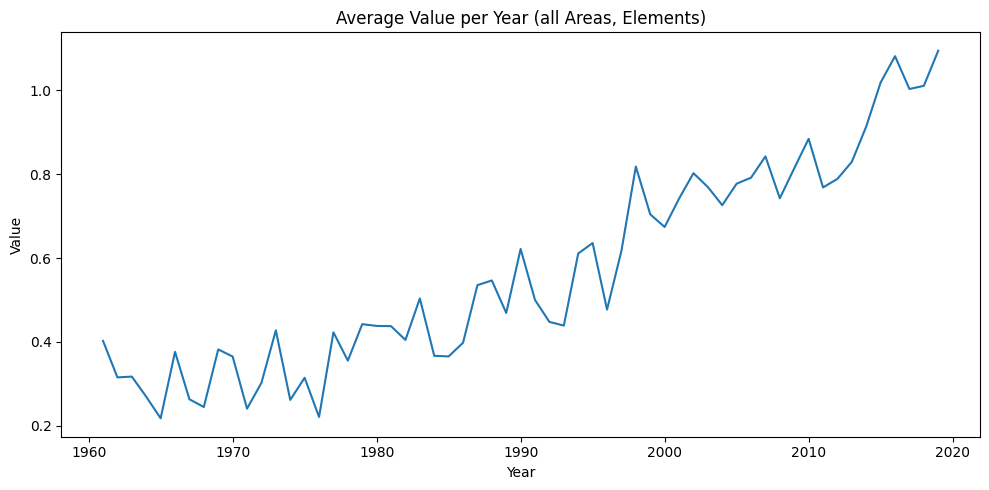

In [33]:
# b) Average value per year (all Areas / Elements)
plt.figure(figsize=(10, 5))
year_mean = df_long.groupby("Year")["Value"].mean().reset_index()
sns.lineplot(data=year_mean, x="Year", y="Value")
plt.title("Average Value per Year (all Areas, Elements)")
plt.tight_layout()
plt.show()

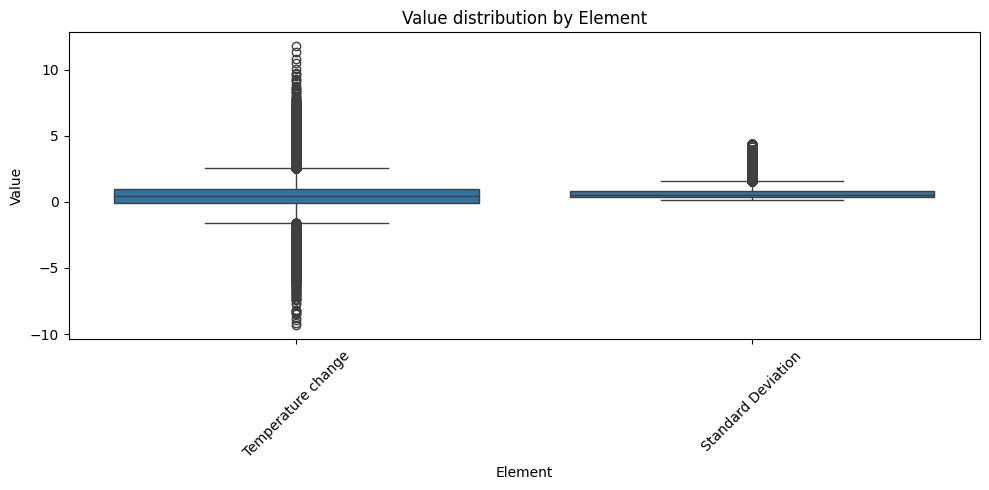

In [34]:
# c) Boxplot by Element to see distribution
plt.figure(figsize=(10, 5))
sns.boxplot(data=df_long, x="Element", y="Value")
plt.xticks(rotation=45)
plt.title("Value distribution by Element")
plt.tight_layout()
plt.show()


In [35]:
# 9. Prepare data for machine learning
# Example: Predict Value using Area, Month, Element, Year

features = ["Area", "Month", "Element", "Year"]
target = "Value"

X = df_long[features]
y = df_long[target]

# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)


In [36]:
# Categorical and numeric columns
categorical_cols = ["Area", "Month", "Element"]
numeric_cols = ["Year"]

# Preprocessing: One-hot encode categorical, pass through numeric
preprocessor = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_cols),
        ("num", "passthrough", numeric_cols),
    ]
)


In [38]:
from sklearn.ensemble import RandomForestRegressor

model = RandomForestRegressor(
    n_estimators=30,      # fewer trees than default 100
    max_depth=8,         # limit tree depth
    max_features="sqrt", # fewer features per split
    n_jobs=-1,           # use all CPU cores
    random_state=42
)

pipe = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("model", model)
])

# This line stays the same
pipe.fit(X_train, y_train)


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['Area', 'Month', 'Element']),
                                                 ('num', 'passthrough',
                                                  ['Year'])])),
                ('model',
                 RandomForestRegressor(max_depth=8, max_features='sqrt',
                                       n_estimators=30, n_jobs=-1,
                                       random_state=42))])

In [39]:
# Evaluate
r2 = pipe.score(X_test, y_test)
print(f"Model R² score: {r2:.3f}")


Model R² score: 0.110


In [40]:
# 10. Save the processed long-format dataset for future use
df_long.to_csv("processed_long_dataset.csv", index=False)
print("Saved processed_long_dataset.csv")


Saved processed_long_dataset.csv
